In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
database = "../hosts_usage/db.sqlite3"

datetime = '2020-08-12 23:00:00'

def ram_usage():

    conn = sqlite3.connect(database)

    df = pd.read_sql("select * from ram_usage", con=conn)
    conn.close()
    df['ram_usage'] = df.usage / df.total * 100
    df.drop(columns=['id', 'total', 'usage', 'hosts_id'], inplace=True)
    df.time = pd.to_datetime(df.time).dt.floor('T')
    df.set_index('time', inplace=True)
    filtro = (df.index >= pd.Timestamp(datetime))
    df = df[filtro]
    df = df.resample('T').ffill()
    return df

<AxesSubplot:xlabel='time'>

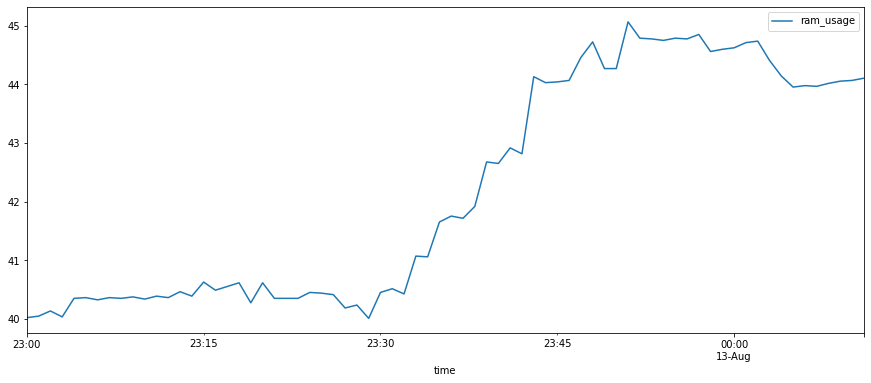

In [2]:
# Ram Usage
df = ram_usage()
df.plot(figsize=(15,6))

In [3]:
# Identificar a melhor ordem para o modelo ARIMA
from statsmodels.tsa.arima_model import ARIMA

orders = [(3, 0, 1), (3, 0, 2), (2, 1, 1), (2, 1, 2), (3, 1, 1), (3, 1, 2), (3, 1, 3)]
best = 10000
for order in orders:
    try:
        model = ARIMA(df.ram_usage, freq='T', order=order).fit()
        erro = (model.resid ** 2).mean()
        if erro < best:
            print(f'ARIMA{order}, erro= {erro}')
            best = erro
    except:
        pass

ARIMA(3, 0, 1), erro= 0.12276623730927515
ARIMA(3, 0, 2), erro= 0.1153266775664123
ARIMA(2, 1, 1), erro= 0.06765874286632674
ARIMA(2, 1, 2), erro= 0.059013063059163956
ARIMA(3, 1, 2), erro= 0.05809446299582567
ARIMA(3, 1, 3), erro= 0.057111854190167274


In [10]:
# Erro quadrático médio
from statsmodels.tsa.arima_model import ARIMA, ARMA

arima = ARIMA(df.ram_usage, freq='T', order=(3, 1, 3)).fit()
(arima.resid ** 2).mean()

0.057111854190167274

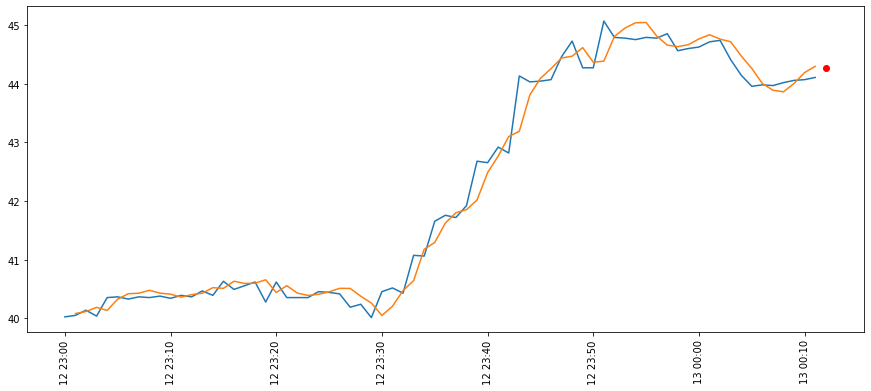

In [11]:
plt.figure(figsize=(15,6))
plt.plot(df.ram_usage)
plt.plot(arima.predict(typ='levels'))
plt.xticks(rotation=90)
plt.scatter(df.index[-1] + np.timedelta64(1, 'm'), arima.forecast()[0], color='red')

In [12]:
# Agora
df.index[-1]

Timestamp('2020-08-13 00:11:00', freq='T')

In [13]:
# Valor agora
df.ram_usage[-1]

44.10723318158826

In [14]:
# Próximo minuto
periodo_futuro = df.index[-1] + np.timedelta64(1, 'm')
periodo_futuro

Timestamp('2020-08-13 00:12:00', freq='T')

In [15]:
# Previsão próx min
arima.forecast()[0]

array([44.27627803])